In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from utils.visualization import show_tensor_image, save_sample
from utils.metrics import psnr, ssim_batch
from utils.attacks import fgsm_attack, pgd_attack
from models.autoencoder import Autoencoder
from models.unet_encoder import UNetEncoder
from models.decoder import LatentDecoder
from models.bisenet_detector import BiSeNetDetector

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

class GTSRBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['Path'])
        image = Image.open(img_path).convert("RGB")
        
        # Crop using ROI
        x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
        image = image.crop((x1, y1, x2, y2))
        
        label = int(row['ClassId'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Create datasets
train_dataset = GTSRBDataset(csv_file='./data/Train.csv', img_dir='./data', transform=transform)
test_dataset = GTSRBDataset(csv_file='./data/Test.csv', img_dir='./data', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [13]:
latent_dim = 128

autoencoder = Autoencoder(latent_dim).to(device)
watermark_encoder = UNetEncoder(latent_dim).to(device)
latent_decoder = LatentDecoder(latent_dim).to(device)
detector = BiSeNetDetector(num_classes=2).to(device)  # 2 classes: watermark/no-watermark

# Optimizers
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
we_optimizer = optim.Adam(watermark_encoder.parameters(), lr=1e-3)
dec_optimizer = optim.Adam(latent_decoder.parameters(), lr=1e-3)
det_optimizer = optim.Adam(detector.parameters(), lr=1e-3)

In [14]:
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
cross_entropy = nn.CrossEntropyLoss()

In [15]:
num_epochs = 5  # For initial demo

lambda_perc = 1.0
lambda_rec = 1.0
lambda_latent = 1.0
lambda_det = 1.0

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # =======================
        # Autoencoder
        # =======================
        z, imgs_rec = autoencoder(imgs)
        loss_rec = mse_loss(imgs_rec, imgs)
        
        # =======================
        # Watermark embedding
        # =======================
        Iw = watermark_encoder(imgs, z)
        
        # =======================
        # Latent decoder
        # =======================
        z_hat = latent_decoder(Iw)
        loss_latent = mse_loss(z_hat, z)
        
        # =======================
        # Detector (dummy target 1 = watermarked)
        # =======================
        det_out = detector(Iw)
        target_det = torch.ones(det_out.shape[0], det_out.shape[1], det_out.shape[2], det_out.shape[3]).to(device)
        loss_det = bce_loss(det_out, target_det)
        
        # =======================
        # Total loss
        # =======================
        total_loss = lambda_perc*loss_rec + lambda_rec*loss_rec + lambda_latent*loss_latent + lambda_det*loss_det
        
        # Backprop
        ae_optimizer.zero_grad()
        we_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        det_optimizer.zero_grad()
        total_loss.backward()
        ae_optimizer.step()
        we_optimizer.step()
        dec_optimizer.step()
        det_optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}] Total Loss: {total_loss.item():.4f}")


Epoch [1/5] Total Loss: 0.0450
Epoch [2/5] Total Loss: 0.0246
Epoch [3/5] Total Loss: 0.0270
Epoch [4/5] Total Loss: 0.0200
Epoch [5/5] Total Loss: 0.0143


In [17]:
# # Pick a batch
# imgs, labels = next(iter(test_loader))
# imgs, labels = imgs.to(device), labels.to(device)

# adv_imgs = fgsm_attack(autoencoder.decoder, imgs, labels, eps=0.03, device=device)
# show_tensor_image(adv_imgs, title="FGSM Adversarial Images")


Original latent sample 0: [-0.00131874  0.07435087  0.16033594  0.03959507  0.00845509]
Recovered latent sample 0: [-0.01271544  0.06026625  0.1399636   0.04313107  0.00382571]
Original latent sample 1: [ 0.0840925  -0.00521566  0.08718634 -0.109091    0.05678159]
Recovered latent sample 1: [ 0.07434831  0.01419582  0.05469457 -0.11442943  0.02883238]
Original latent sample 2: [ 0.00391841 -0.04088037 -0.05386234  0.04071109  0.05819058]
Recovered latent sample 2: [ 0.01386923 -0.01512385 -0.04328201  0.07930627  0.0725989 ]


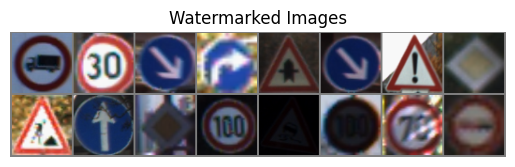

In [18]:
# Embed watermark
with torch.no_grad():
    z, _ = autoencoder(imgs)
    Iw = watermark_encoder(imgs, z)
    z_hat = latent_decoder(Iw)

# Compare latent
for i in range(3):
    print(f"Original latent sample {i}: {z[i,:5].cpu().numpy()}")
    print(f"Recovered latent sample {i}: {z_hat[i,:5].cpu().numpy()}")

show_tensor_image(Iw, title="Watermarked Images")


In [19]:
psnr_val = psnr(imgs, Iw)
ssim_val = ssim_batch(imgs, Iw)
print(f"PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

# Save a sample
save_sample(Iw, "./results/sample_outputs/watermarked.png")


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [ ]:
torch.save(autoencoder.state_dict(), "./results/autoencoder.pth")
torch.save(watermark_encoder.state_dict(), "./results/watermark_encoder.pth")
torch.save(latent_decoder.state_dict(), "./results/latent_decoder.pth")
torch.save(detector.state_dict(), "./results/detector.pth")
